# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


## Preperations

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif


%pip install ucimlrepo

# Load the dataset

from ucimlrepo import fetch_ucirepo


### Load the dataset and prepare the target variable

In [25]:
# Load the dataset
df = fetch_ucirepo(id=193)

# Extract data as pandas DataFrames
X = df.data.features
y = df.data.targets

# Drop the first column of the target variable
y = y.iloc[:, 1]  # Selecting the NSP column (Normal, suspect, pathologic)

### Feature Selection with SelectKBest



In [27]:
# Feature selection with SelectKBest
bestfeatures = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
fit = bestfeatures.fit(X, y)  # Fit on the data

# Combine scores and feature names for reference
dfscores = pd.DataFrame(fit.scores_, columns=['Score'])
dfcolumns = pd.DataFrame(X.columns, columns=['Specs'])
featureScores = pd.concat([dfcolumns, dfscores], axis=1)

# Select the top 10 features
top_features = featureScores.nlargest(10, 'Score')['Specs']
X_selected = X[top_features]

# Drop 'Mode' and 'Median' columns due to high correlation with 'Mean'
X_selected = X_selected.drop(['Mode', 'Median'], axis=1)

In [28]:
# Splitting the dataset with selected features
X_train_selected, X_test_selected, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Standardize the features
scaler_selected = StandardScaler()
X_train_scaled_selected = scaler_selected.fit_transform(X_train_selected)
X_test_scaled_selected = scaler_selected.transform(X_test_selected)

## Model Choice

As baseline models, we chose Logistic Regression and a Support Vector Machine (SVM) due to their simplicity and effectiveness.

**Logistic Regression**: A  model that provides interpretability through feature coefficients. It serves as a benchmark for evaluating more complex models.

**Support Vector Machine (SVM)**: SVM complements Logistic Regression by capturing non-linear relationships through kernels like RBF, offering a comparison between linear and non-linear approaches.


## Implementation





### Compiling and Training for Logistic Regression

In [ ]:
# Initialize and train the logistic regression model with class weights
lr_model = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Automatically adjust class weights based on class frequencies
)

# Train the model on the scaled training data
lr_model.fit(X_train_scaled_selected, y_train)

print("Logistic Regression model has been successfully trained.")

### Compiling and Training for Support Vector Machine

In [ ]:
# Initialize and train an SVM with a non-linear kernel and class weights
from sklearn.svm import SVC

# Initialize SVM model with class weights
svm_model = SVC(
    kernel='rbf',  # Non-linear kernel
    probability=True,  # Enables probability estimation
    random_state=42,
    class_weight='balanced'  # Automatically adjusts weights for imbalanced classes
)

# Train the SVM model on the scaled training data
svm_model.fit(X_train_scaled_selected, y_train)

print("SVM model with non-linear kernel has been successfully trained.")

# Evaluation

## Metrics to Evaluate the Model

### Primary Metrics
- **F1-Score**: Balances Precision and Recall for each class.
- **Recall**: Ensure no pathological cases are missed (focus on sensitivity).

### Secondary Metrics
- **Confusion Matrix**: Analyze detailed classification errors.
- **Accuracy**: Provides an overall performance snapshot but is less reliable for imbalanced datasets.
- **Precision**: Evaluate the proportion of correct positive predictions to avoid excessive false alarms.



## Evaluation Logistic Regression

In [32]:
# Function to evaluate and visualize model performance
def evaluate_and_visualize_model(model, X_test, y_test, model_name="Model"):
    """
    Evaluates and visualizes the performance of a model.

    Parameters:
    model: Trained model to evaluate
    X_test: Scaled test features
    y_test: True labels for the test set
    model_name: Name of the model (e.g., "Logistic Regression" or "SVM")
    """
    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.2f}")

    # Generate a classification report
    print("\nClassification Report:")
    report = classification_report(y_test, y_pred, target_names=["Normal", "Suspect", "Pathologic"], output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    print(df_report)

    # Visualize the classification report as a heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(df_report.iloc[:-3, :3], annot=True, cmap="Blues", fmt=".2f", linewidths=0.5)
    plt.title(f"Precision, Recall, and F1-Score ({model_name} Heatmap Table)")
    plt.xlabel("Metrics")
    plt.ylabel("Classes")
    plt.show()

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Suspect", "Pathologic"])
    disp.plot(cmap="viridis")
    plt.title(f"Confusion Matrix ({model_name})")
    plt.show()



--- Logistic Regression ---
Accuracy: 0.85

Classification Report:
              precision    recall  f1-score    support
Normal         0.989362  0.837838  0.907317  333.00000
Suspect        0.549020  0.875000  0.674699   64.00000
Pathologic     0.595238  0.862069  0.704225   29.00000
accuracy       0.845070  0.845070  0.845070    0.84507
macro avg      0.711206  0.858302  0.762080  426.00000
weighted avg   0.896377  0.845070  0.858544  426.00000


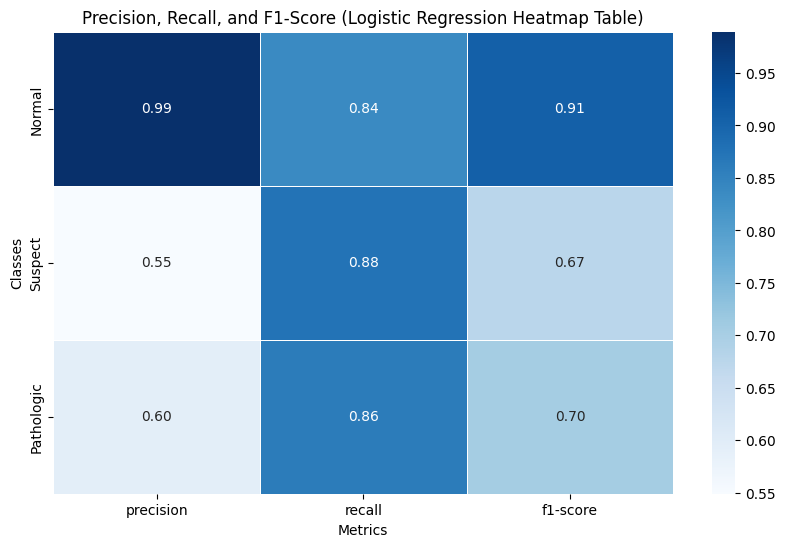

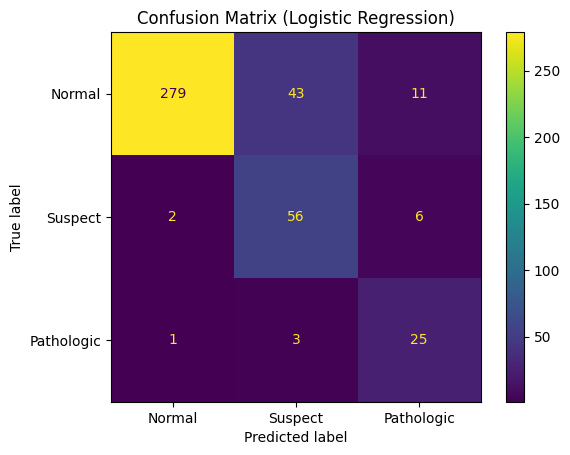

In [19]:
# Evaluate the trained logistic regression model
evaluate_and_visualize_model(lr_model, X_test_scaled_selected, y_test, model_name="Logistic Regression")


## Evaluation Support Vector Machine

### Evaluation Support Vectoe Machine with Non-Linear Kernel (rbf)


--- SVM ---
Accuracy: 0.88

Classification Report:
              precision    recall  f1-score     support
Normal         0.993056  0.858859  0.921095  333.000000
Suspect        0.584158  0.921875  0.715152   64.000000
Pathologic     0.756757  0.965517  0.848485   29.000000
accuracy       0.875587  0.875587  0.875587    0.875587
macro avg      0.777990  0.915417  0.828244  426.000000
weighted avg   0.915539  0.875587  0.885212  426.000000


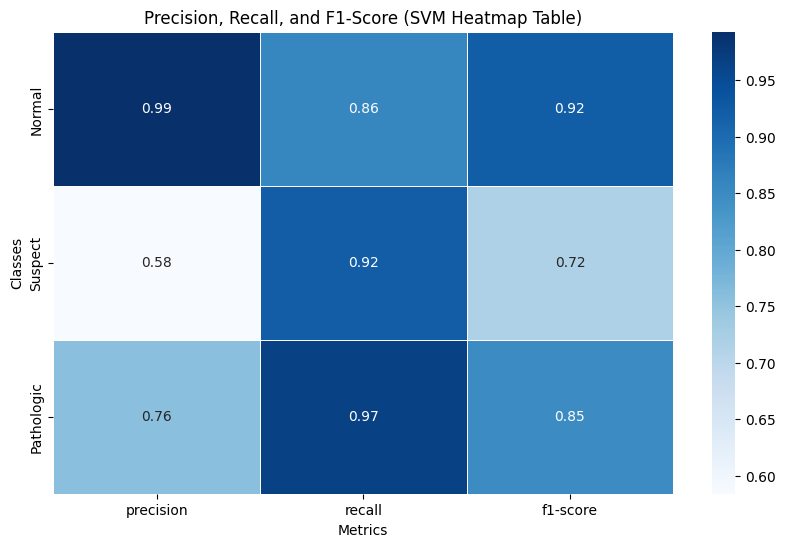

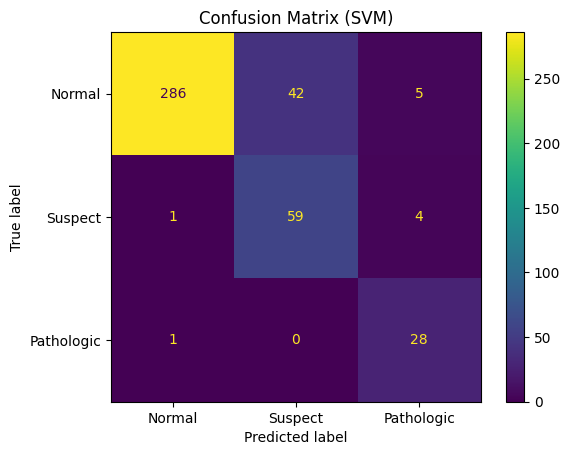

In [33]:
# Evaluate the trained SVM model
evaluate_and_visualize_model(svm_model, X_test_scaled_selected, y_test, model_name="SVM")


## Comparing Logistic Regression and Support Vector Machine (kernel='rbf')

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


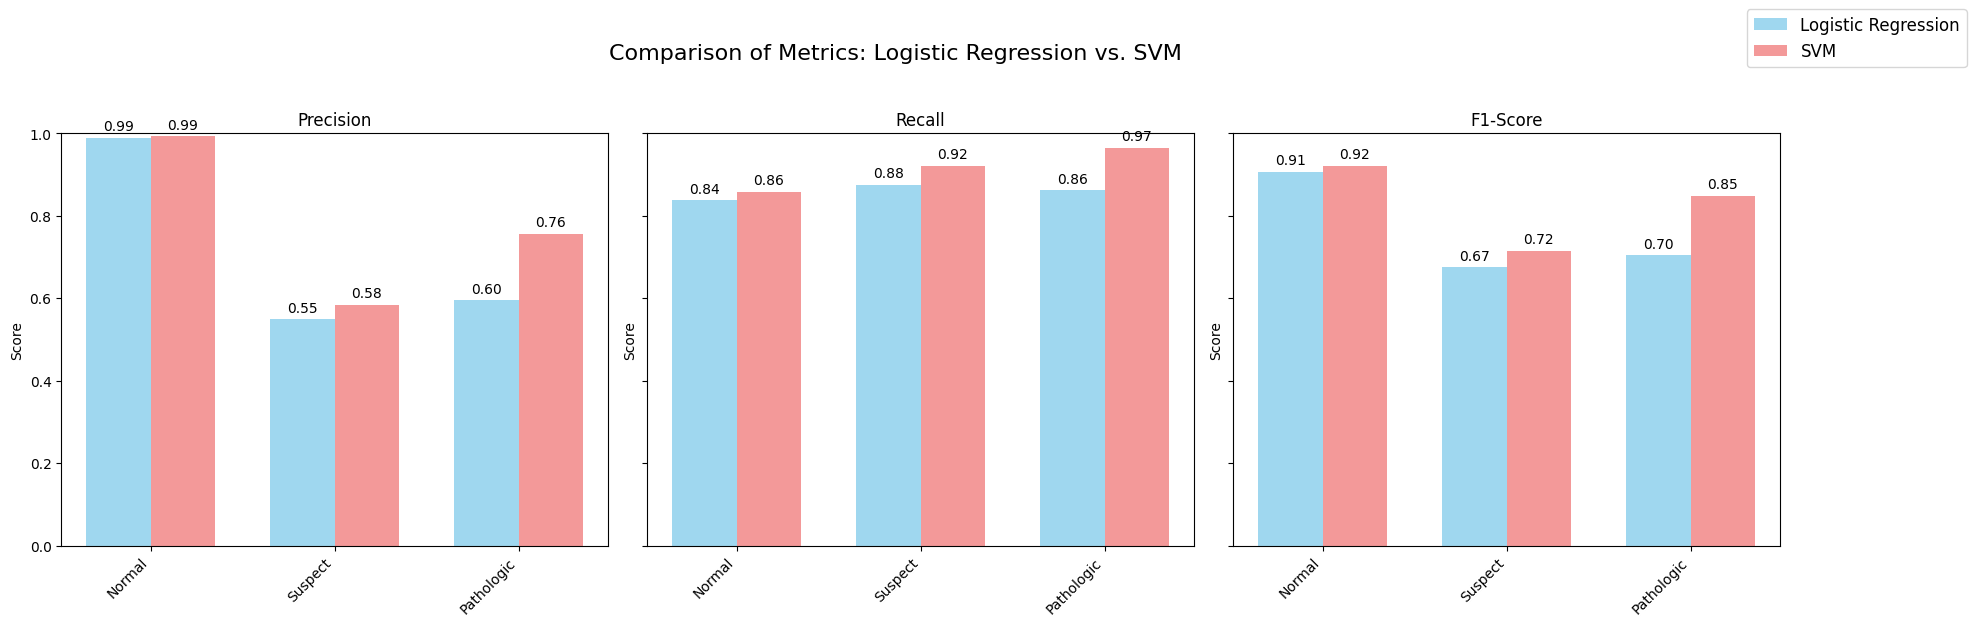


Model Comparison Summary:

Logistic Regression Weighted Average Metrics:
Precision: 0.896
Recall: 0.845
F1-Score: 0.859

SVM Weighted Average Metrics:
Precision: 0.916
Recall: 0.876
F1-Score: 0.885


In [34]:
def compare_models(X_train_scaled, y_train, X_test_scaled, y_test):
    """
    Trains and compares SVM and Logistic Regression models.
    Returns the comparison metrics and creates visualization plots.
    """
    # Train Logistic Regression with class weights
    lr_model = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=42,
        class_weight='balanced'  # Automatically adjust class weights
    )
    lr_model.fit(X_train_scaled, y_train)

    # Train SVM with RBF kernel and class weights
    svm_model = SVC(
        kernel='rbf',  # Non-linear kernel
        probability=True,
        random_state=42,
        class_weight='balanced'  # Automatically adjust class weights
    )
    svm_model.fit(X_train_scaled, y_train)

    # Get predictions
    y_pred_logreg = lr_model.predict(X_test_scaled)
    y_pred_svm = svm_model.predict(X_test_scaled)

    # Get classification reports
    report_logreg = classification_report(y_test, y_pred_logreg,
                                          target_names=["Normal", "Suspect", "Pathologic"],
                                          output_dict=True)
    report_svm = classification_report(y_test, y_pred_svm,
                                       target_names=["Normal", "Suspect", "Pathologic"],
                                       output_dict=True)

    # Create comparison DataFrame with consistent naming
    comparison_data = {
        'precision_LogReg': [report_logreg[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_LogReg': [report_logreg[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_LogReg': [report_logreg[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]],
        'precision_SVM': [report_svm[label]['precision'] for label in ["Normal", "Suspect", "Pathologic"]],
        'recall_SVM': [report_svm[label]['recall'] for label in ["Normal", "Suspect", "Pathologic"]],
        'f1-score_SVM': [report_svm[label]['f1-score'] for label in ["Normal", "Suspect", "Pathologic"]]
    }

    comparison_df = pd.DataFrame(comparison_data,
                                 index=["Normal", "Suspect", "Pathologic"])

    # Create visualization
    metrics = ["Precision", "Recall", "F1-Score"]
    classes = comparison_df.index
    x = np.arange(len(classes))
    width = 0.35

    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

    for i, metric in enumerate(metrics):
        if metric == "F1-Score":
            logreg_values = comparison_df['f1-score_LogReg']
            svm_values = comparison_df['f1-score_SVM']
        else:
            logreg_values = comparison_df[f'{metric.lower()}_LogReg']
            svm_values = comparison_df[f'{metric.lower()}_SVM']

        ax = axes[i]
        rects1 = ax.bar(x - width/2, logreg_values, width, label='Logistic Regression',
                        color='skyblue', alpha=0.8)
        rects2 = ax.bar(x + width/2, svm_values, width, label='SVM',
                        color='lightcoral', alpha=0.8)

        ax.set_title(metric)
        ax.set_xticks(x)
        ax.set_xticklabels(classes, rotation=45, ha='right')
        ax.set_ylabel("Score")
        ax.set_ylim(0, 1)

        # Add value labels on bars
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width()/2, height),
                            xytext=(0, 3),
                            textcoords="offset points",
                            ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

    # Add a single legend for all plots
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.1, 1.05), fontsize=12)

    fig.suptitle("Comparison of Metrics: Logistic Regression vs. SVM", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Print summary statistics
    print("\nModel Comparison Summary:")
    print("\nLogistic Regression Weighted Average Metrics:")
    print(f"Precision: {report_logreg['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_logreg['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_logreg['weighted avg']['f1-score']:.3f}")

    print("\nSVM Weighted Average Metrics:")
    print(f"Precision: {report_svm['weighted avg']['precision']:.3f}")
    print(f"Recall: {report_svm['weighted avg']['recall']:.3f}")
    print(f"F1-Score: {report_svm['weighted avg']['f1-score']:.3f}")

    return comparison_df


comparison_df = compare_models(X_train_scaled_selected, y_train, X_test_scaled_selected, y_test)
